In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Classification Algorithms. Part II

Contents:

- [Evaluation Metrics](#1.-Evaluating-a-Classification-Model)
- [Cross Validation](#2.-Cross-validation-for-parameter-tuning,-model-selection-and-feature-selection)

## 1. Evaluating a Classification Model

sklearn evaluation metrics reference [page](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

- We need a way to choose between models: different model types (knn, linear regression, logistic regression, decision trees, SVM, etc), and hyper-parameters.
- Use a **model evaluation procedure** to estimate how well a model will generalize to out-of-sample data
- Requieres a **model evaluation metric** to quantify the model performance:

    - Accuracy
    - Confusion Matrix
    - Sensitivity
    - Specificity
    - Recall

In [2]:
# load the Pima indian diabetes dataset
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/pima.csv'
pima = pd.read_csv(url)
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Each row represents one patient, and the label column indicates 1 if the patient has diabetes, and 0 if the patient does not have diabetes.

In [3]:
pima.label.value_counts() # 

0    500
1    268
Name: label, dtype: int64

In [4]:
pima.columns

Index(['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree',
       'age', 'label'],
      dtype='object')

Columns:

- **pregnant**: number of pregnancies the patient has had
- **glucose**: plasma glucose concentration a 2 hours in an oral glucose tolerance test
- **bp**: diastolic blood pressure (mm Hg)
- **skin**: Triceps skin fold thickness (mm)
- **insulin**: 2-Hour serum insulin (mu U/ml)
- **bmi**: Body mass index (weight in kg/(height in m)^2)
- **pedigree**: diabetes pedigree function (a synthesis of the diabetes history in relatives and the genetic relationship of those relatives to the subject)
- **Age**: age (years)

**Goal:** to predict the diabetes status of a patient given their health measurements.

In [5]:
# define X and y
feature_cols = ['pregnant','glucose','bp','skin','insulin','bmi','age']
X = pima[feature_cols]
y = pima.label

**Train-Test split**: Split the dataset into two datasets:

- Training dataset: used to fit (train) the model (75%)
- Test dataset: used to test the performance of the model (25%)

In [6]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [7]:
X_train.shape, X_test.shape

((576, 7), (192, 7))

In [8]:
# train a knn model on the training set
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [9]:
# make class predictions for the testing set
y_test_pred = knn_clf.predict(X_test)

### 1.1. Classification accuracy

In [10]:
# print the first 30 true and predicted responses
print('True:',y_test.to_numpy()[0:30])
print('Pred:',y_test_pred[0:30])

True: [1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0]
Pred: [1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0]


In [11]:
from sklearn import metrics

The **classification accuracy** is the percentage of correct predictions

In [12]:
print(100*metrics.accuracy_score(y_test, y_test_pred))

71.35416666666666


Comparing the **true** and **predicted** responses

### 1.2. Confusion matrix

Table that describes the performance of a classification model

In [13]:
print(metrics.confusion_matrix(y_test,y_test_pred))

[[102  32]
 [ 23  35]]


Confusion Matrix:

<td> <img src="confusion_matrix.png" alt="Drawing" style="width: 400px;"/> </td>

**Basic terminology**

- **True Positives (TP)**: we correctly predicted that the patient is diabetic
- **True Negatives (TN)**: we correctly predicted that the patient is non-diabetic
- **False Positives (FP)**: we incorrectly predicted that the patient is diabetic
- **False Negatives (FN)**: we incorrectly predicted that the patient is non-diabetic

In [14]:
# save confusion matrix and slice it into four pieces
confusion = metrics.confusion_matrix(y_test, y_test_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

### 1.3. Metrics computed from a confusion matrix

**Sensitivity (aka recall):** When the actual value is positive (1), how often is the prediction correct?

In [15]:
TP/(TP+FN)

0.603448275862069

In [16]:
# using sklearn
metrics.recall_score(y_test,y_test_pred)

0.603448275862069

**Specificity:** When the actual value is negative (0), how often is the prediction correct?

In [17]:
TN/(TN+FP)

0.7611940298507462

**Precision:** When a positive value is predicted, how often is the prediction correct?

In [18]:
TP/(TP+FP)

0.5223880597014925

In [19]:
# using sklearn
metrics.precision_score(y_test,y_test_pred)

0.5223880597014925

**F1 score**

In [20]:
metrics.f1_score(y_test,y_test_pred)

0.5599999999999999

### Balanced accuracy

In [21]:
metrics.balanced_accuracy_score(y_test,y_test_pred)

0.6823211528564076

**Which metrics should you focus on?**

- Choice of metric depends on your objective
- Examples:
    - **Spam filter** (positive class is "spam"): Optimize for **precision or specificity** because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
    - **Fraudulent transaction detector** (positive class is "fraud"): Optimize for **sensitivity** because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

## 2. Cross-validation for parameter tuning, model selection and feature selection

**Motivation:** Need a way to choose between machine learning models, and to choose hyper-parameters
- Goal is to estimate likely performance of a model on **out-of-sample data**


**k-fold Cross validation:**
- Create a bunch of train/test splits, calculate the testing accuracy for each and average the result together

In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.
For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that we have broken the data into 5 "folds".

<td> <img src="cross_validation.png" alt="Drawing" style="width: 400px;"/> </td>

Cross-validation recommendations:
- k can be any number, but k=10 is generally recommended
- For classification problems, each class should be represented with equal proportions in each of the K folds (scikit-learn's cross_val_score function does this by default)

In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
#Use 10-fold cross-validation with k=5 (n_neighbors) for knn classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn_clf, X, y, cv = 10, scoring = 'accuracy')

In [24]:
scores

array([0.67532468, 0.79220779, 0.71428571, 0.67532468, 0.66233766,
       0.74025974, 0.7012987 , 0.79220779, 0.71052632, 0.73684211])

In [25]:
# use average accuracy as an estimate of out-of-sample accuracy
scores.mean()

0.7200615174299384

**Example 1: parameter tuning** 

**Goal:** Select the best hyper paramerers for knn classifier on the pima dataset

In [34]:
# search for an optimal value of k for knn
k_range = list(range(1, 50))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy') 
    k_scores.append(scores.mean())

Text(0, 0.5, 'Cross-Validated Accuracy')

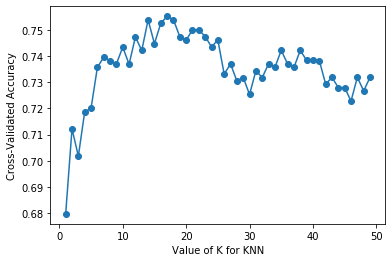

In [35]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores,'o-')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

Conclusion: the best knn model uses k=14

**Example 2: Model Selection**

**Goal:** Compare the best KNN model with logistic regression on the pima dataset

In [40]:
# 10-fold cross-validation with the best KNN model
knn_clf = KNeighborsClassifier(n_neighbors=14)
np.round(cross_val_score(knn_clf, X, y, cv=10, scoring='accuracy').mean(),2)

0.75

In [41]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(max_iter=1000)
np.round(cross_val_score(log_clf, X, y, cv=10, scoring='accuracy').mean(),2)

0.77

Conclusion: higher accuracy with a logistic regression model

**Example 3: feature selection**

**Goal:** Select whether the glucose feature should be included in the knn model on the prima dataset

In [45]:
# all features
features = ['pregnant','glucose','bp','skin','insulin','bmi','age']
X = pima[features]
y = pima.label
knn_clf.fit(X,y)
np.round(cross_val_score(knn_clf, X, y, cv=5, scoring='accuracy').mean(),2)

0.76

In [46]:
# drop glucose feature
features = ['pregnant','bp','skin','insulin','bmi','age']
X = pima[features]
y = pima.label
knn_clf.fit(X,y)
np.round(cross_val_score(knn_clf, X, y, cv=5, scoring='accuracy').mean(),2)

0.69

Conclusion: higher accuracy if we use the glucose feature